## Read Attendance data

In [5]:
import pandas as pd
def load_and_process_afl_data(data_url: str) -> pd.DataFrame:
	df = pd.read_csv(data_url)
	df = df.dropna(subset=["Crowd", "Home v Away Teams"])
	teams_split = df["Home v Away Teams"].str.split(" v ", expand=True)
	df["home_team"] = teams_split[0]
	df["away_team"] = teams_split[1]
	df["Crowd"] = df["Crowd"].astype(int)
	return df
data_url = "../data/parsed_real_afl_attendance_2024.csv"
attendance_df_2024 = load_and_process_afl_data(data_url)

### Average attendance by home team sorted

In [6]:
def average_attendance_by_team(attendance_df: pd.DataFrame) -> pd.Series:
# Calculate average attendance per home team for 2024 season
    average_attendance_2024 = attendance_df_2024.groupby("home_team")["Crowd"].mean().sort_values(ascending=False).head(20)
    return average_attendance_2024

In [7]:
team_attendance_2024 = average_attendance_by_team(attendance_df_2024)
team_attendance_2024

home_team
Collingwood         64905.416667
Carlton             58310.636364
Essendon            50478.454545
Fremantle           46814.583333
Richmond            44402.500000
Sydney              43391.500000
Geelong             43378.416667
West Coast          43149.500000
Adelaide            41421.250000
Port Adelaide       39700.000000
Hawthorn            36036.545455
Western Bulldogs    35268.153846
Melbourne           34928.636364
Brisbane            29553.538462
St Kilda            29257.363636
North Melbourne     21954.000000
Gold Coast          15063.333333
GWS                 12781.500000
Name: Crowd, dtype: float64

#### Plot

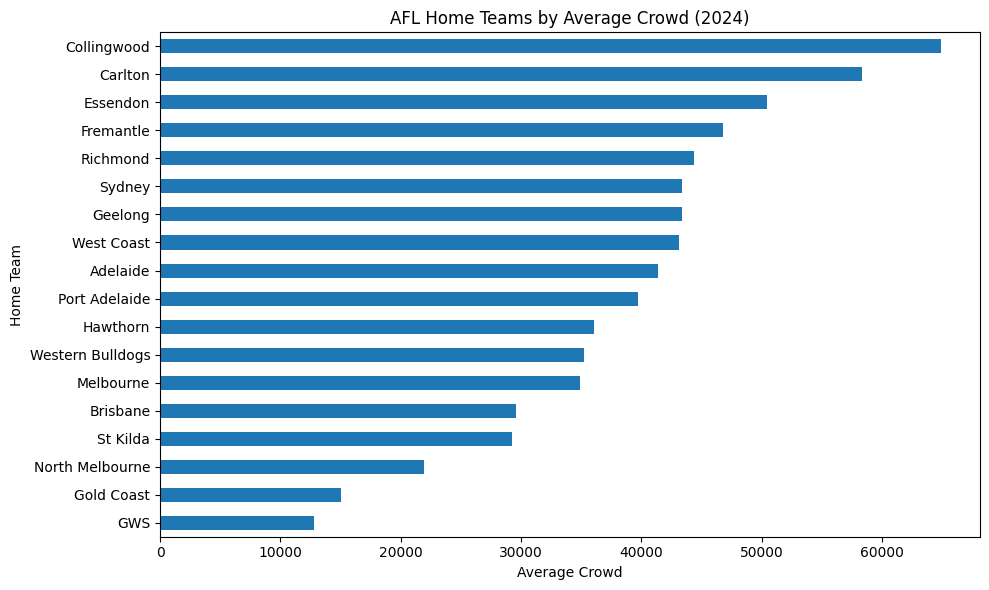

In [ ]:
import matplotlib.pyplot as plt

top_home = attendance_df_2024.groupby("home_team")["Crowd"].mean().sort_values(ascending=False).head(18)

top_home.plot(kind="barh", figsize=(10, 6), title="AFL Home Teams by Average Crowd (2024)")
plt.xlabel("Average Crowd")
plt.ylabel("Home Team")
plt.gca().invert_yaxis()  # So biggest is on top
plt.tight_layout()
plt.show()


### Attendance by Venue

In [ ]:
venue_summary = attendance_df_2024.groupby("Venue")["Crowd"].agg(["count", "mean", "sum"]).sort_values("mean", ascending=False)
venue_summary.rename(columns={"count": "Games", "mean": "Average Crowd", "sum": "Total Crowd"}, inplace=True)
venue_summary.head(100)

,Games,Average Crowd,Total Crowd
Venue,,,
MCG,50,60730.700000,3036535
Optus Stadium,22,46562.454545,1024374
Adelaide Oval,29,40965.275862,1187993
SCG,13,39036.000000,507468
Marvel Stadium,43,32771.860465,1409190
GMHBA Stadium,9,31666.888889,285002
Gabba,12,31263.250000,375159
People First Stadium,9,16919.444444,152275
Manuka Oval,3,12932.000000,38796


In [5]:
# Some entries are empty, so we'll use errors='coerce'
df["parsed_date"] = pd.to_datetime("2024 " + df["Date"], errors="coerce", format="%Y %a %d %b %I:%M%p")

# Drop games after September 1st (i.e., finals)
df_regular = df[df["parsed_date"] < "2024-09-01"]
%store df_regular

Stored 'df_regular' (DataFrame)


In [6]:

# Filter only games at the MCG
mcg_df = df_regular[df_regular["Venue"] == "MCG"]

mcg_home_summary = mcg_df.groupby("home_team")["Crowd"].mean().sort_values(ascending=False)
mcg_home_summary

home_team
Carlton        78141.200000
Collingwood    72770.666667
Essendon       72585.000000
Geelong        71236.500000
St Kilda       69517.000000
Hawthorn       52920.000000
Richmond       50203.000000
Melbourne      37810.600000
Name: Crowd, dtype: float64

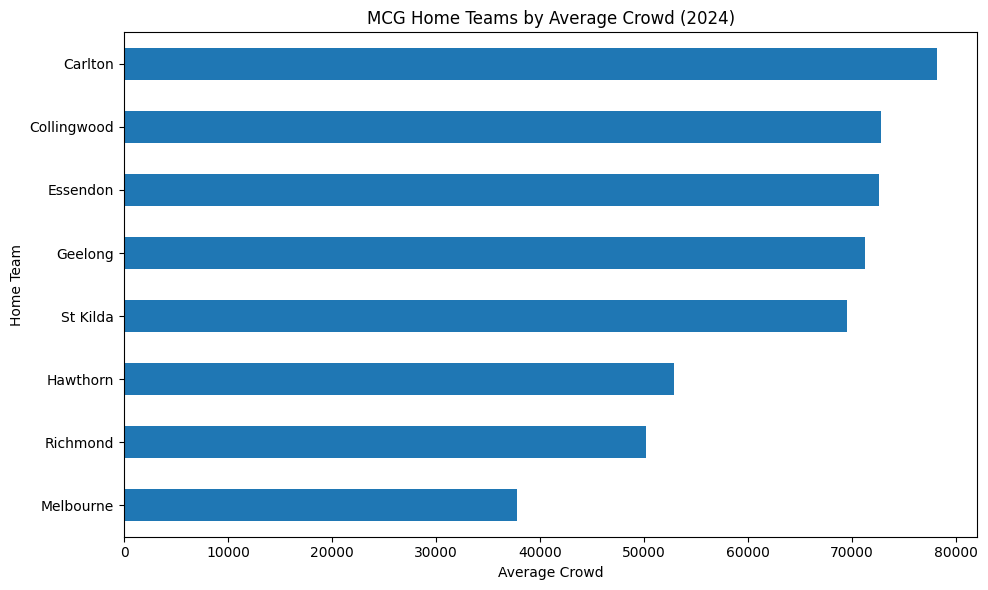

In [7]:
mcg_home_summary.plot(kind="barh", figsize=(10, 6), title="MCG Home Teams by Average Crowd (2024)")
plt.xlabel("Average Crowd")
plt.ylabel("Home Team")
plt.gca().invert_yaxis()  # So biggest is on top
plt.tight_layout()
plt.show()

In [ ]:
# Clean up 'Round' in case it's a float or string
df["Round"] = df["Round"].astype(int)

round_summary = df.groupby("Round")["Crowd"].mean()
round_summary.plot(marker='o', figsize=(10, 5), title="Average AFL Crowd by Round (2024)")
plt.ylabel("Average Crowd")
plt.xlabel("Round")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Group by team and round
home_round_attendance = df_regular.groupby(["home_team", "Round"])["Crowd"].mean().reset_index()
attendance_matrix = home_round_attendance.pivot(index="Round", columns="home_team", values="Crowd")


In [ ]:
# Similar matrix for away games
away_round_attendance = df_regular.groupby(["away_team", "Round"])["Crowd"].mean().reset_index()
away_matrix = away_round_attendance.pivot(index="Round", columns="away_team", values="Crowd")


In [ ]:
for team in attendance_matrix.columns:
    home_series = attendance_matrix[team]
    away_series = away_matrix[team]

    plt.figure(figsize=(8, 4))

    # Plot home crowd trend line (interpolated)
    plt.plot(
        home_series.index,
        home_series.interpolate(method="linear"),
        color="steelblue",
        label="Home (Interpolated)"
    )

    # Real home game markers
    plt.scatter(
        home_series.index,
        home_series,
        color="darkblue",
        s=50,
        zorder=5,
        label="Home Game"
    )

    # Away game markers (dots only, no line)
    plt.scatter(
        away_series.index,
        away_series,
        color="orange",
        s=50,
        zorder=4,
        marker="x",
        label="Away Game"
    )

    plt.title(f"{team} – Crowd Trend (Home vs Away)")
    plt.xlabel("Round")
    plt.ylabel("Crowd")
    plt.ylim(0, max(attendance_matrix.max().max(), away_matrix.max().max()) * 1.1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
attendance_matrix.head(10)

In [ ]:
capacity_df = pd.read_csv("venue_capacity.csv")
capacity_df.head(20)

In [ ]:
team_venue_avg = df_regular.groupby(["home_team", "Venue"])["Crowd"].mean().reset_index()


In [ ]:
venue_only_merged = pd.merge(venue_summary, capacity_df, on="Venue", how="left")
venue_only_merged.rename(columns={"Average Crowd": "avg_crowd"}, inplace=True)
venue_only_merged["fill_pct"] = venue_only_merged["avg_crowd"] / venue_only_merged["Capacity"]
venue_fill_summary = venue_only_merged.groupby("Venue")["fill_pct"].mean().sort_values(ascending=False)
venue_fill_summary = venue_fill_summary.round(3)  # Format as 0.### (e.g. 0.86 = 86% full)

In [ ]:
# Merge crowd data with venue capacity
merged = pd.merge(team_venue_avg, capacity_df, on="Venue", how="left")
merged.rename(columns={"Crowd": "avg_crowd"}, inplace=True)
merged["fill_pct"] = merged["avg_crowd"] / merged["Capacity"]
fill_summary = merged.groupby("home_team")["fill_pct"].mean().sort_values(ascending=False)
fill_summary = fill_summary.round(3)  # Format as 0.### (e.g. 0.86 = 86% full)


In [ ]:
fill_summary.plot(kind="barh", figsize=(10, 6), title="Average Stadium Fill % by Team")
plt.xlabel("Average Fill Rate")
plt.xlim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
venue_fill_summary.plot(kind="barh", figsize=(10, 6), title="Average Stadium Fill % by Team")
plt.xlabel("Average Fill Rate")
plt.xlim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()
